In [250]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import statsmodels.api as sm
import random
import matplotlib.pyplot as plt

### Estimating the Cost of Equity

To estimate the cost of equity for Dixon Technologies, I first calculated weekly returns for Dixon, its peers (PG Electroplast, Amber Enterprises, Kaynes Technologies, and Syrma SGS Technology), and the market index. Using these, I ran regressions to obtain the beta for each peer and took their average as the industry levered beta.

Next, I unlevered this industry beta using the formula:

$ \beta_{unlevered} = \frac{\beta_{industry}}{1+(1-tax_{rate}*(D/E)_{industry})} $ 
 
​
 
Then, I relevered it for Dixon’s capital structure:

$ \beta_{levered} = {\beta_{unlevered}}*[{1+(1-tax_{rate}*(D/E)_{company})}] $ 

Assumed tax rate: 21%

To estimate the market risk premium (MRP), I averaged historical monthly market returns. Finally, I used the CAPM formula to compute the cost of equity:

$ R_e = R_f + \beta_{levered}*MRP$



In [251]:
## 1. Estimating the cost of equity

ticker = ['DIXON.NS','PGEL.NS','AMBER.NS','KAYNES.NS','SYRMA.NS','^NSEI']
weekly_data = round(pd.DataFrame(yf.download(ticker,start = '2023-09-18',end= '2025-06-27',interval='1wk'))['Close'],2)
weekly_data.index.name = None
weekly_data = weekly_data.rename(columns={'^NSEI':'Nifty50'})
weekly_data


C:\Users\SOURABH\AppData\Local\Temp\ipykernel_38672\3992256673.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  weekly_data = round(pd.DataFrame(yf.download(ticker,start = '2023-09-18',end= '2025-06-27',interval='1wk'))['Close'],2)
[*********************100%***********************]  6 of 6 completed


Ticker,AMBER.NS,DIXON.NS,KAYNES.NS,PGEL.NS,SYRMA.NS,Nifty50
2023-09-18,2967.30,4803.71,2050.15,177.40,531.76,19674.25
2023-09-25,2976.80,5287.36,2300.30,177.55,609.48,19638.30
2023-10-02,2920.90,5126.92,2549.70,180.95,635.89,19653.50
2023-10-09,2971.65,5338.04,2668.55,196.59,636.83,19751.05
2023-10-16,3036.60,5518.93,2456.05,210.45,654.27,19542.65
...,...,...,...,...,...,...
2025-05-26,6491.50,14692.00,5980.00,771.45,538.80,24750.70
2025-06-02,6396.50,14855.00,5731.50,772.55,534.90,25003.05
2025-06-09,6468.00,14311.00,5475.50,751.55,522.75,24718.60
2025-06-16,6519.00,14047.00,5864.50,739.40,506.65,25112.40


In [252]:
weekly_return = weekly_data.pct_change() ## Weekly returns for peers
weekly_return = weekly_return.dropna(axis=0) ## Drop 'NAN' values
weekly_return

Ticker,AMBER.NS,DIXON.NS,KAYNES.NS,PGEL.NS,SYRMA.NS,Nifty50
2023-09-25,0.003202,0.100683,0.122015,0.000846,0.146156,-0.001827
2023-10-02,-0.018779,-0.030344,0.108421,0.019150,0.043332,0.000774
2023-10-09,0.017375,0.041179,0.046613,0.086433,0.001478,0.004963
2023-10-16,0.021857,0.033887,-0.079631,0.070502,0.027386,-0.010551
2023-10-23,-0.042581,-0.026473,-0.031270,-0.051984,-0.085515,-0.025350
...,...,...,...,...,...,...
2025-05-26,0.013426,-0.021772,-0.007387,-0.003809,0.004755,-0.004122
2025-06-02,-0.014635,0.011094,-0.041555,0.001426,-0.007238,0.010196
2025-06-09,0.011178,-0.036621,-0.044665,-0.027183,-0.022715,-0.011377
2025-06-16,0.007885,-0.018447,0.071044,-0.016167,-0.030799,0.015931


In [253]:
index = weekly_return['Nifty50']
EMS = ['DIXON.NS','PGEL.NS','AMBER.NS','KAYNES.NS','SYRMA.NS']

## Estimating regression beta for peers
X = sm.add_constant(index)

Beta = []

for i in EMS:
    model = sm.OLS(weekly_return[i],X).fit()
    # print(model.params)
    beta = round((model.params['Nifty50']),2)
    Beta.append(beta)

avg_EMS_Beta = np.mean(Beta) ## Industry Beta




In [254]:

## Calculating unlevered Beta

debt = []
equity = []
EMS_ticker = yf.Tickers(EMS)

for item in EMS_ticker.tickers.items() :
    
    
    balance_sheet = pd.DataFrame(item[1].balance_sheet)
    total_debt = round(balance_sheet.loc['Total Debt']/10**7,2)
    debt.append(total_debt.iloc[0])

    mkt_cap = round((item[1].info.get('marketCap')/10**7),2)
    equity.append(mkt_cap)
total_debt = np.sum(debt)
total_eqty = np.sum(equity)

industry_DER = round(total_debt/total_eqty,2)

tax_rate = 0.21

unlevered_Beta = round(avg_EMS_Beta/(1+(1-tax_rate)*industry_DER),2)
ind_unlevered_Beta = (Beta/(1+(1-tax_rate)*industry_DER)).round(2) ## Final Industry unlevered Beta




In [255]:
## Estimating Beta for Dixon Tech 
dixon = yf.Ticker('DIXON.NS')
dixon_debt = round(dixon.balance_sheet.loc['Total Debt'].iloc[0]/10**7,2)
dixon_equity = round((dixon.info.get('marketCap')/10**7),2)

dixon_DER = round(dixon_debt/dixon_equity,2)
dixon_DER

dixon_levered_beta = round(unlevered_Beta*(1+(1-tax_rate)*dixon_DER),2)
dixon_debt

company_levered_beta = (ind_unlevered_Beta*(1+(1-tax_rate)*dixon_DER)).round(2) ## Final Dixon Beta


In [256]:
## Market Risk Premium

rf = 	6.36/100
nifty50_yearly = pd.DataFrame(yf.download('^NSEI',start = '2020-07-06',end= '2025-07-06',interval='3mo'))['Close']
rm = np.nanmean([round(nifty50_yearly.pct_change(periods=4),2)])

mrp = round(rm-rf,2) ## Final Market Risk Premium


C:\Users\SOURABH\AppData\Local\Temp\ipykernel_38672\106685759.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty50_yearly = pd.DataFrame(yf.download('^NSEI',start = '2020-07-06',end= '2025-07-06',interval='3mo'))['Close']
[*********************100%***********************]  1 of 1 completed


In [257]:
## Estimating the COE 

r_e = rf + dixon_levered_beta*mrp
COE = rf + company_levered_beta*mrp ## Final COE for Dixon



### Estmating the Cost of Debt

To estimate the cost of debt, I’ve used a straightforward approach: dividing the company’s latest interest expense by its total outstanding debt.

$Cost Of Debt = \frac{Interest Expense}{Total Outstanding Debt}$

Limitations of this approach:

- $\bold{\text{Based on historical data}}$: The interest expense used reflects past borrowing terms, which may not represent the current cost of borrowing.
- $\bold{\text{Assumes uniform rates}}$: It assumes all debt carries the same interest rate, which may not hold true, especially in firms with a mix of instruments.
 


In [258]:
#COD

dixon_int_exp = round(dixon.incomestmt.loc['Interest Expense'].iloc[0]/10**7,2)
r_d = round(dixon_int_exp/dixon_debt,2)

company_int_exp = round(dixon.incomestmt.loc['Interest Expense']/10**7,2)
company_debt = round(dixon.balance_sheet.loc['Total Debt']/10**7,2)
COD = (company_int_exp/company_debt).round(2)


### Estimating the weighted average cost of capital

To estimate the weights for cost of equity (COE) and cost of debt (COD) in the WACC calculation, I use the company’s current market capitalization as a proxy for equity value and the total outstanding debt as the measure of debt. These are then used to compute the relative weights of equity and debt in the capital structure:



$w_e = \frac{\text{market cap}}{\text{market cap + total debt}}$

$w_d = \frac{\text{total debt}}{\text{market cap + total debt}}$



In [259]:
#Calculating weight of debt & equity

w_e = round(dixon_equity/(dixon_equity+dixon_debt),2)
w_d = 1-w_e


In [260]:
#WACC
wacc = r_e*w_e + r_d*w_d*(1-tax_rate)
wacc

0.19130300000000003

### Estimating the intrinsic growth

For estimating the intrinsic grwoth of the company we need the following:

- Invested Capital
- EBIT
- Capital Expenditure
- Net change in working capital
- Depriciation

Steps for calculating the intrinsic hrowth rate of the company:

- Calculate the return on invested capital by :
 $\frac{EBIT*(1- tax_{rate})}{\text{invested capital}}$

- Now take the average of the ROIC for the past 4 years to obtain the average ROIC for the company 
- Next, calculate the total reinvestment into the company by : CapEx + NWC - Depriciation
- Reinvestment rate is estimated as : $\frac{ReInvestment}{EBIT*(1-tax_{rate})}$
- Finally, the intrinsic growth rate is estimated as : $ReInvestment_{rate}*ROIC$



In [261]:
## Estimating Growth

invested_capital = round(pd.DataFrame(dixon.balance_sheet).loc['Invested Capital']/10**7,2)

EBIT = round(pd.DataFrame(dixon.incomestmt).loc['EBIT']/10**7,2)


ROIC = EBIT*(1-tax_rate)/invested_capital
avg_ROIC = np.nanmean(ROIC)
med_ROIC = np.median(ROIC)

ic_mean = np.mean(invested_capital)
ic_std_dev = np.std(invested_capital)

In [262]:
CapEx = round(-pd.DataFrame(dixon.cashflow).loc['Capital Expenditure Reported']/10**7,2)
NWC   = round(-pd.DataFrame(dixon.cashflow).loc['Change In Working Capital']/10**7,2)
Depriciation = round(pd.DataFrame(dixon.cashflow).loc['Depreciation And Amortization']/10**7,2)
ReInvestment = CapEx+NWC-Depriciation
rr = ReInvestment/EBIT*(1-tax_rate)
avg_rr = round(np.mean(rr),2)




In [263]:
intrinsic_growth_rate = rr*ROIC
avg_growth_rate = np.mean(intrinsic_growth_rate)
med_growth_rate = np.median(intrinsic_growth_rate)




In [264]:
## DCF Valuator

(PV_of_FCFF,
PV_of_Terminal_Value,
price_per_share) = DCF_valuator(tax_rate,wacc,avg_rr,med_growth_rate) ## DCF valuator function is called
print(f'Fair value for Dixon: Rs.{price_per_share}')


Fair value for Dixon: Rs.1304.9252449772555


C:\Users\SOURABH\AppData\Local\Temp\ipykernel_38672\3775129866.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  FCFF_foreacst.loc['EBIT',col] = EBIT[0]
C:\Users\SOURABH\AppData\Local\Temp\ipykernel_38672\3775129866.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_cash = cash[0]
C:\Users\SOURABH\AppData\Local\Temp\ipykernel_38672\3775129866.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_debt = debt[0]


### Monte Carlo Simulation

In [265]:
import scipy.stats
import random
from dataclasses import dataclass

In [266]:
def graph(dist,title,x_label,y_label):


    samples = np.array(dist.getSample(10000)).flatten()
    plt.hist(samples, bins=100, density=True, alpha = 0.7, color='royalblue',edgecolor = 'black')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()
    

In [267]:
@dataclass
class SimulationInputs():

    rf_dist  = ot.Normal(6.36/100,0.005)
    mrp_dist = ot.Normal(0.09,0.001)

    min_eqty = np.min(equity)
    max_eqty = np.max(equity)
    mode_eqty = np.mean(equity)
    

    min_debt = np.min(debt)
    max_debt = np.max(debt)
    mode_debt = np.mean(debt)
    

    min_unlevered_beta = np.min(ind_unlevered_Beta)
    max_unlevered_beta = np.max(ind_unlevered_Beta)
    mode_unlevered_beta = np.median(ind_unlevered_Beta)
   

    min_company_beta = np.min(company_levered_beta)
    max_company_beta = np.max(company_levered_beta)
    mode_company_beta = np.median(company_levered_beta)
   

    #COD Distribution
    cod_min = np.min(COD)
    cod_max = np.max(COD)
    cod_med = np.median(COD)
   
    min_ROIC = np.min(ROIC)
    max_ROIC = np.max(ROIC)
    med_ROIC = np.median(ROIC)
   

   
    mean_rr = np.mean(rr)

  
    n_sims = 1000   



modelData = SimulationInputs()





In [268]:
def DCF_MC_inputs(modelData):
    rf = random.normalvariate(6.36/100,0.005)
    mrp = random.normalvariate(0.09,0.001)
    tax_rate = random.uniform(0.21,0.30)
    equity = random.triangular(modelData.min_eqty,modelData.max_eqty,modelData.mode_eqty)
    debt = random.triangular(modelData.min_debt,modelData.max_debt,modelData.mode_debt)
    unlevered_Beta = random.triangular(modelData.min_company_beta,modelData.max_unlevered_beta,modelData.mode_company_beta)
    company_Beta = random.triangular(modelData.min_company_beta,modelData.max_company_beta,modelData.mode_company_beta)
    COD = random.triangular(modelData.cod_min,modelData.cod_max,modelData.cod_med)
    ROIC = random.triangular(modelData.min_ROIC,modelData.max_ROIC,modelData.med_ROIC)
    rr = random.normalvariate(modelData.mean_rr,0.10)

    #COE
    COE = rf+company_Beta*mrp

    #WACC
    WACC = (equity/(equity+debt))*COE + (debt/(equity+debt))*COD*(1-tax_rate)

    ##intrinsic growth rate
    growth_rate = rr*ROIC


    return(rf,
           mrp,
           tax_rate,
           equity,
           debt,
           unlevered_Beta,
           company_Beta,
           COD,
           COE,
           ROIC,
           rr,
           WACC,
           growth_rate)


### DCF Valuator

This is the main function used for DCF valuation of the company.

- $\bold{\text{Step 1:}}$ A dataframe ('FCFF_forecast') is initiated to forecast the free cashflow to the firm. This model forecasts the FCFF for 5 years into the future.
- $\bold{\text{Step 2:}}$ The DCF valuator functions takes 5 inputs : tax_rate, Reinvestment rate , WACC and the intrinsic growth rate.
- $\bold{\text{Step 3:}}$ The first column of the dataframe is taken as the base column.
- $\bold{\text{Step 4:}}$ First the forecast of EBIT is generated as the EBIT of the previous period multiplied by the intrinsic growth rate
- $\bold{\text{Step 5:}}$ Second post tax EBIT is generated by multiplying the forecasted EBIT by (1 - tax_rate)
- $\bold{\text{Step 6:}}$ Mid-year convention is used assuming cashflow happens first in the 6th month of the FY and then at the end of the FY
- $\bold{\text{Step 7:}}$ Discount factor for a particlar year is calculated as the $\frac{1}{(1+wacc)}$ raised to mid-year convention value of the particular year.
- $\bold{\text{Step 8:}}$ FCFF is forecasted as the product of post tax EBIT and (1- reinvestment rate).
- $\bold{\text{Step 9:}}$ PV of the forecasted cashflow is generated by multiplying the cashflow by the discount factor that year.
- $\bold{\text{Step 10:}}$ Terminal value of the firm is calculated by multiplying the final year forecasted FCFF multiplying by the intrinsic growth rate and discounting this by dividing by (growth_rate - terminal growth for the firm.) For Dixon, terminal growth rate is assumed to be 15%.
- $\bold{\text{Step 10:}}$ Value of operating assets for the firm is calculated as : Terminal_value + PV of FCFF
- $\bold{\text{Step 11:}}$ Value of equity is calculated as : Value of Opt. assets + Cash and Cash equivalents - Debt
- $\bold{\text{Step 12:}}$ Finally the value of per share of the firm is obtained as value of equity of firm/ no. of share O/S





In [269]:
def DCF_valuator(tax_rate,WACC,rr,growth_rate):
    FCFF_foreacst = pd.DataFrame(columns=['Mar-25(A)','Mar-26(F)','Mar-27(F)','Mar-28(F)','Mar-29(F)','Mar-30(F)'],
                                index=['EBIT','Tax Rate','EBIT(1-t)','ReInvestment Rate','FCFF','Mid-Year Convention','Discounting Factor','PV of FCFF'])
    FCFF_foreacst.loc['Tax Rate'] = tax_rate
    FCFF_foreacst.loc['ReInvestment Rate'] = rr
    # FCFF_foreacst['Mar-26(F)'].loc['Mid-Year Convention'].fillna(0,inplace=True)
    # FCFF_foreacst['Mid-Year Convention']  -0.5

    for i,col in enumerate(FCFF_foreacst.columns):
        # print(i,col)
        if i == 0:
            FCFF_foreacst.loc['EBIT',col] = EBIT[0]
            FCFF_foreacst.loc['EBIT(1-t)',col] = round(FCFF_foreacst.loc['EBIT',col] * (1-tax_rate),2)
            
        else:
            
            FCFF_foreacst.loc['EBIT',col] = round(FCFF_foreacst.loc['EBIT',FCFF_foreacst.columns[i-1]]*(1+growth_rate),2)
            FCFF_foreacst.loc['EBIT(1-t)',col] = round(FCFF_foreacst.loc['EBIT',col] * (1-tax_rate),2)
            FCFF_foreacst.loc['Mid-Year Convention',col] = i-0.5
            FCFF_foreacst.loc['Discounting Factor',col]  = 1/((1+wacc)**FCFF_foreacst.loc['Mid-Year Convention',col])
            
        
        FCFF_foreacst.loc['FCFF',col] = round(FCFF_foreacst.loc['EBIT(1-t)',col]*(1-FCFF_foreacst.loc['ReInvestment Rate',col]),2)
        FCFF_foreacst.loc['PV of FCFF',col] = round(FCFF_foreacst.loc['FCFF',col]*FCFF_foreacst.loc['Discounting Factor',col],2)

#Calculation of Terminal Value

    term_FCFF = FCFF_foreacst.loc['FCFF','Mar-30(F)']*(1+growth_rate)
    terminal_growth_rate = 0.058

    Terminal_Value = term_FCFF/(WACC-terminal_growth_rate)
    
    

    PV_of_FCFF = round(np.sum(FCFF_foreacst.loc['PV of FCFF']),2)
    PV_of_Terminal_Value = Terminal_Value*(FCFF_foreacst.loc['Discounting Factor','Mar-30(F)'])

    Value_Of_Opt_Assets = PV_of_FCFF+ PV_of_Terminal_Value

    cash = round(pd.DataFrame(dixon.balance_sheet).loc['Cash And Cash Equivalents']/10**7,2)
    latest_cash = cash[0]
    debt = round(pd.DataFrame(dixon.balance_sheet).loc['Total Debt']/10**7,2)
    latest_debt = debt[0]

    value_of_equity = Value_Of_Opt_Assets+latest_cash-latest_debt
    num_of_shares = round(pd.DataFrame(dixon.balance_sheet).loc['Share Issued'].iloc[0]/10**7,2)

    
    price_per_share = value_of_equity/num_of_shares
    

    return(PV_of_FCFF,PV_of_Terminal_Value,price_per_share)

In [270]:
def DCF_single_simulation(modelData):
    (rf,
    mrp,
    tax_rate,
    equity,
    debt,
    unlevered_Beta,
    company_Beta,
    COD,
    COE,
    ROIC,
    rr,
    WACC,
    growth_rate)=DCF_MC_inputs(modelData)

    (PV_of_FCFF,PV_of_Terminal_Value,price_per_share) = DCF_valuator(tax_rate,WACC,rr,growth_rate)

    return(rf,
    mrp,
    tax_rate,
    equity,
    debt,
    unlevered_Beta,
    company_Beta,
    COD,
    COE,
    ROIC,
    rr,
    WACC,
    growth_rate,
    PV_of_FCFF,
    PV_of_Terminal_Value,
    price_per_share
    )

In [271]:
all_results = [DCF_single_simulation(modelData) for i in range(modelData.n_sims)]
colmns = [
    'rf',
    'mrp',
    'tax_rate',
    'equity',
    'debt',
    'unlevered_Beta',
    'company_Beta',
    'COD',
    'COE',
    'ROIC',
    'rr',
    'WACC',
    'growth_rate',
    'PV_of_FCFF',
    'PV_of_Terminal_Value',
    'price_per_share']
DCF_df = pd.DataFrame(all_results,columns=colmns)
DCF_df

C:\Users\SOURABH\AppData\Local\Temp\ipykernel_38672\3775129866.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  FCFF_foreacst.loc['EBIT',col] = EBIT[0]
C:\Users\SOURABH\AppData\Local\Temp\ipykernel_38672\3775129866.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_cash = cash[0]
C:\Users\SOURABH\AppData\Local\Temp\ipykernel_38672\3775129866.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_debt = debt[0]
C:\U

,rf,mrp,tax_rate,equity,debt,unlevered_Beta,company_Beta,COD,COE,ROIC,rr,WACC,growth_rate,PV_of_FCFF,PV_of_Terminal_Value,price_per_share
0,0.066413,0.091436,0.288369,43753.566458,739.733104,1.358173,1.568158,0.136496,0.209798,0.232161,0.395473,0.207925,0.091813,3139.80,3812.080531,1081.689457
1,0.062056,0.089377,0.218051,45038.146035,1438.925803,1.428614,1.305221,0.134203,0.178713,0.177129,0.368443,0.176429,0.065262,3364.08,4779.084099,1279.577093
2,0.055559,0.088437,0.288673,70110.053032,1446.327843,1.577888,1.329940,0.108925,0.173175,0.294066,0.456796,0.171241,0.134328,3146.15,5700.790479,1396.483468
3,0.067708,0.089410,0.296342,26187.896098,1078.012563,1.270809,1.506447,0.133735,0.202399,0.271387,0.464905,0.198117,0.126169,3002.38,4299.297854,1139.795325
4,0.067911,0.090709,0.213059,25407.564675,1693.675819,1.467047,1.480526,0.135356,0.202208,0.276444,0.506450,0.196228,0.140005,3208.66,4837.201406,1263.413855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.071428,0.090576,0.294819,45336.444729,569.997285,1.341221,1.475903,0.152325,0.205110,0.219312,0.554410,0.203897,0.121588,2476.32,3362.548996,896.803820
996,0.060533,0.090126,0.281802,60256.104474,1261.897688,1.381530,1.391877,0.166254,0.185978,0.352213,0.570174,0.184612,0.200823,2975.02,5733.351025,1373.465287
997,0.053403,0.089943,0.226017,54857.990354,1329.579215,1.571814,1.263115,0.165577,0.167011,0.211956,0.464896,0.166092,0.098538,3075.76,5281.295859,1315.107286
998,0.053196,0.089157,0.253534,51953.496454,628.402957,1.545628,1.332039,0.092204,0.171957,0.332040,0.536693,0.170725,0.178203,3148.34,6436.581745,1519.071718


In [272]:
# samples = np.array(DCF_df['price_per_share'].getSample(10000)).flatten()
def hist_plot(data,col_name):
    perc = [10,25,50,75,90,99]
    perc_values = np.percentile(data,perc)
    plt.hist(data, bins=200, density=True, alpha = 0.5, color='skyblue',edgecolor = 'black',)

    colors = ['purple', 'blue', 'green', 'orange', 'red','black']

    for p,value,color in zip(perc,perc_values,colors):
        plt.axvline(value, color=color, linestyle='--', linewidth=2, label=f'{p}th percentile')
        
    plt.legend(loc = 'center',bbox_to_anchor=(1.25,.5))
    plt.title(f'{col_name} distribution')
    plt.xlabel('Value')
    plt.ylabel('Ferquency')
    plt.grid(True)
    plt.show()
    

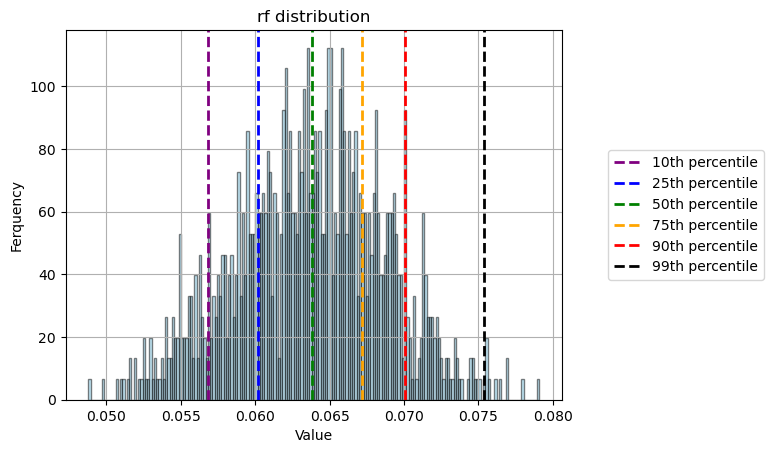

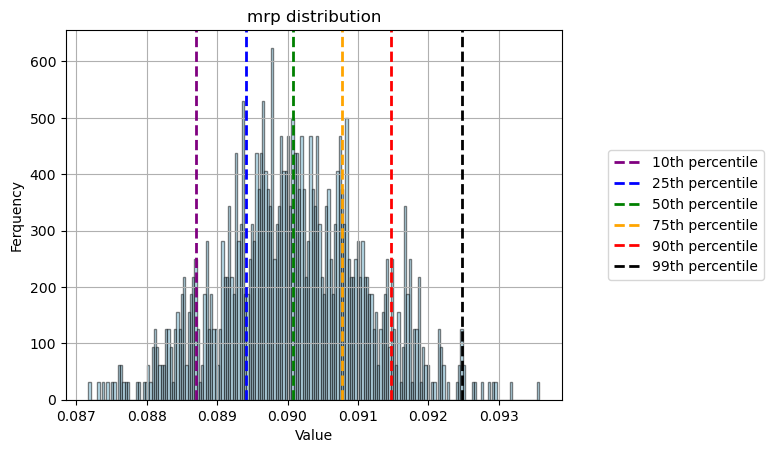

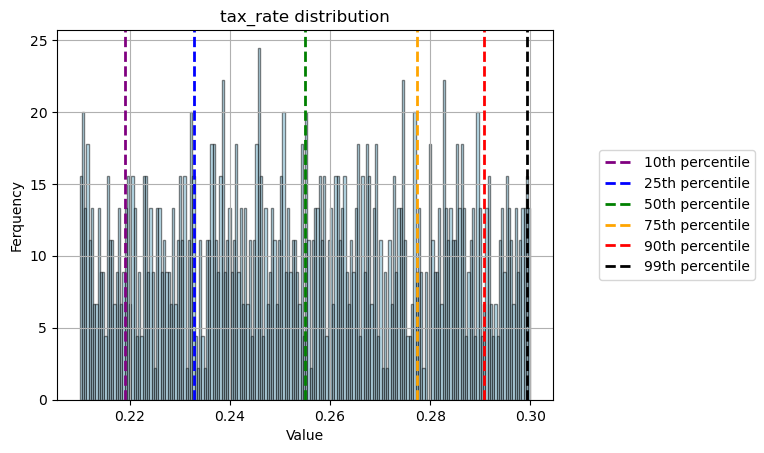

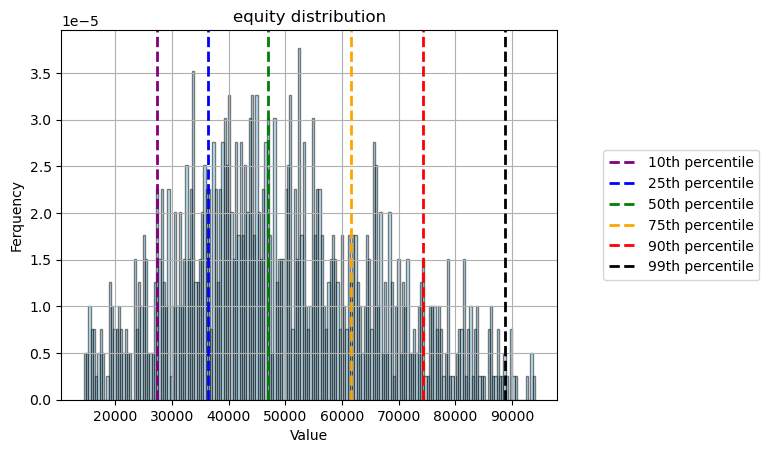

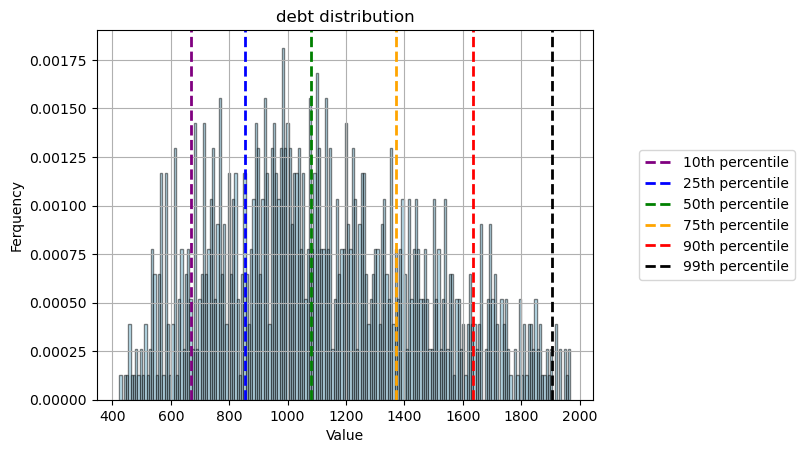

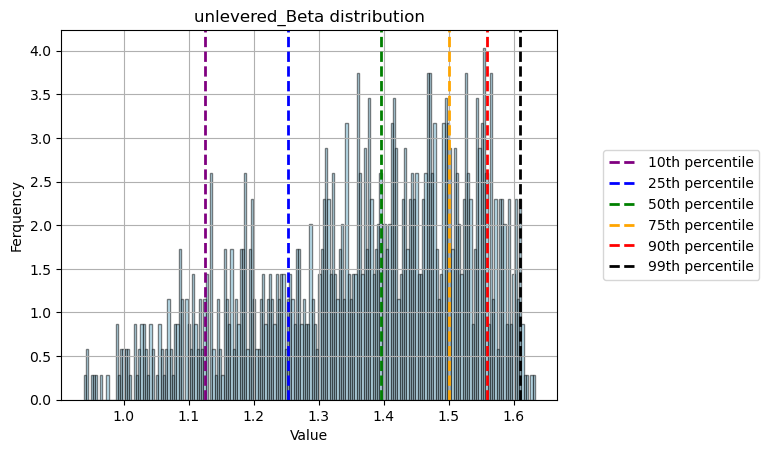

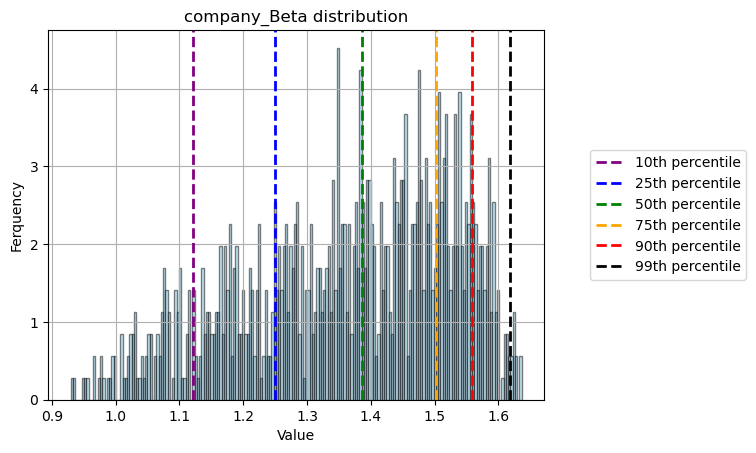

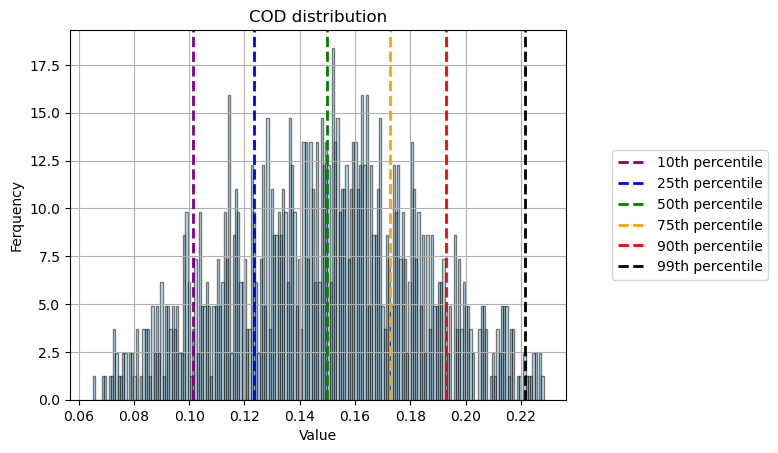

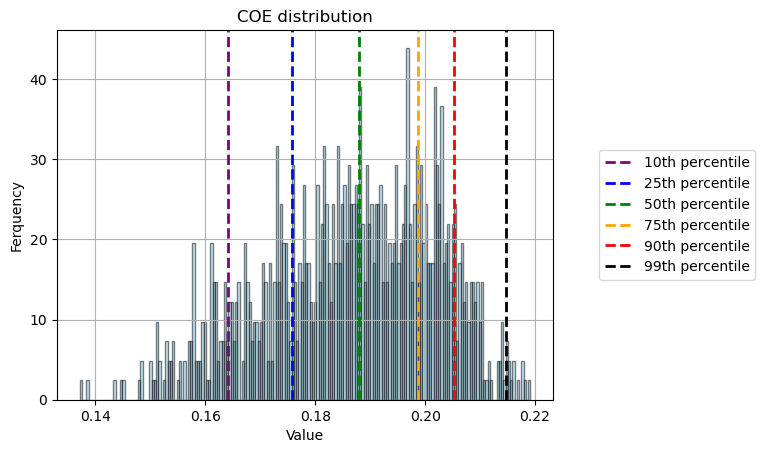

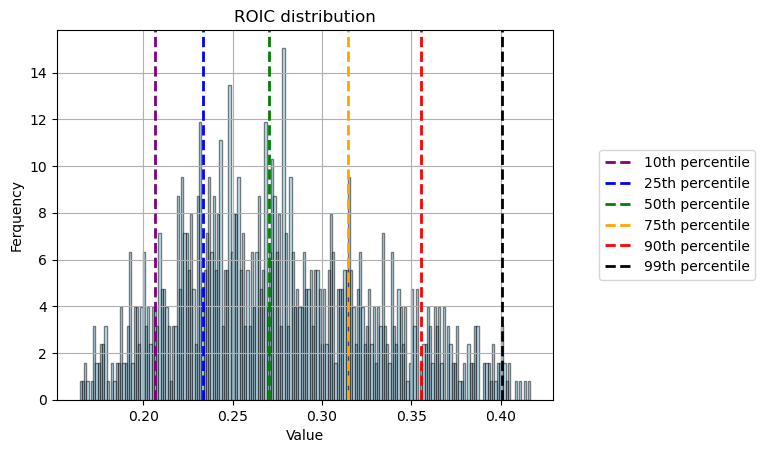

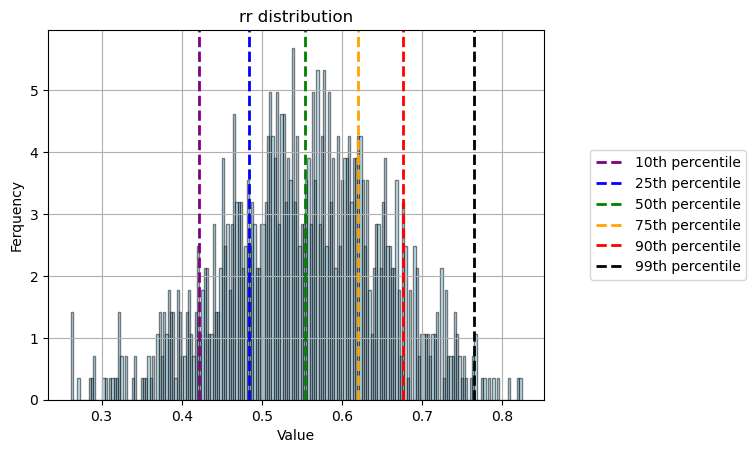

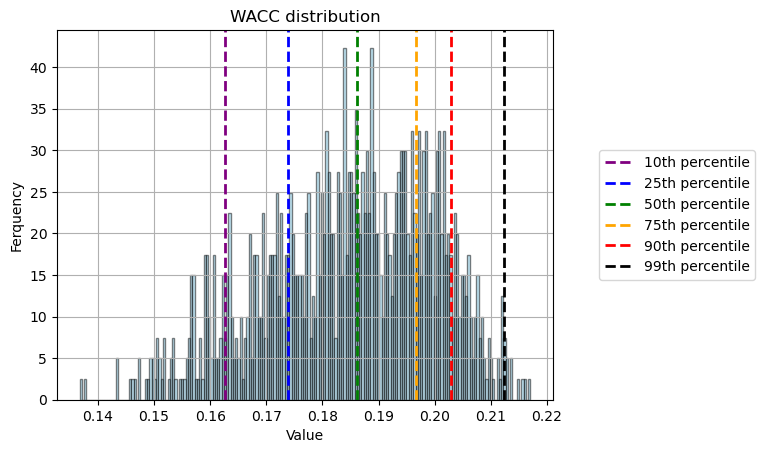

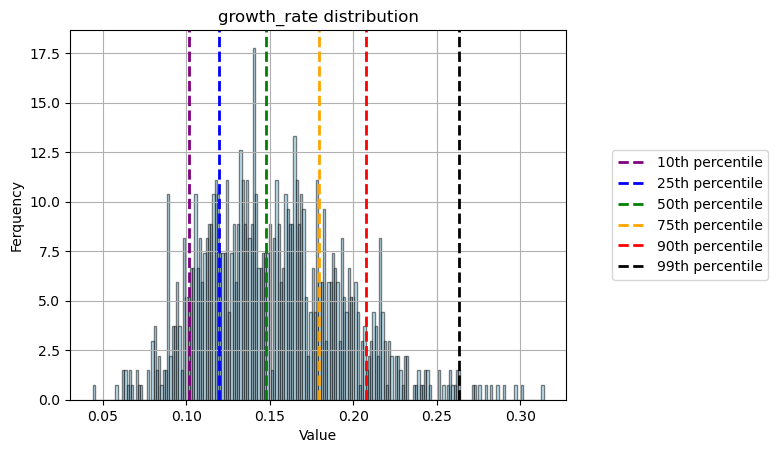

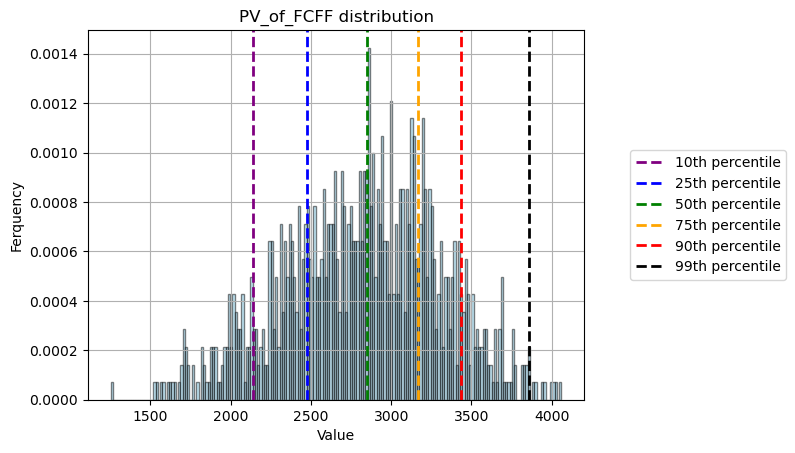

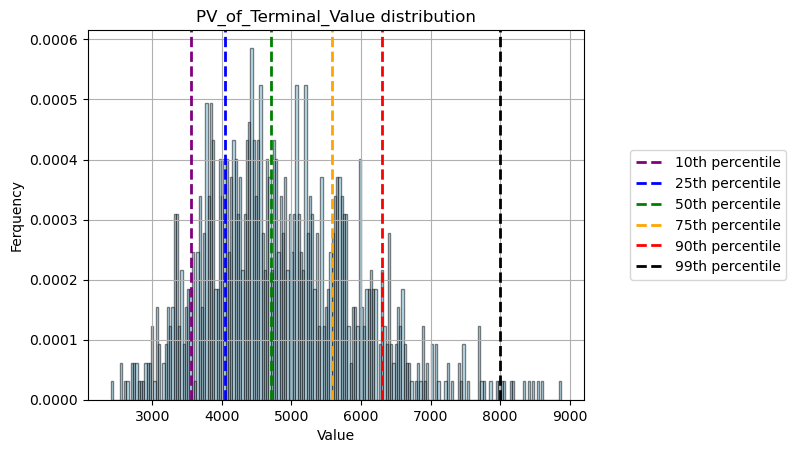

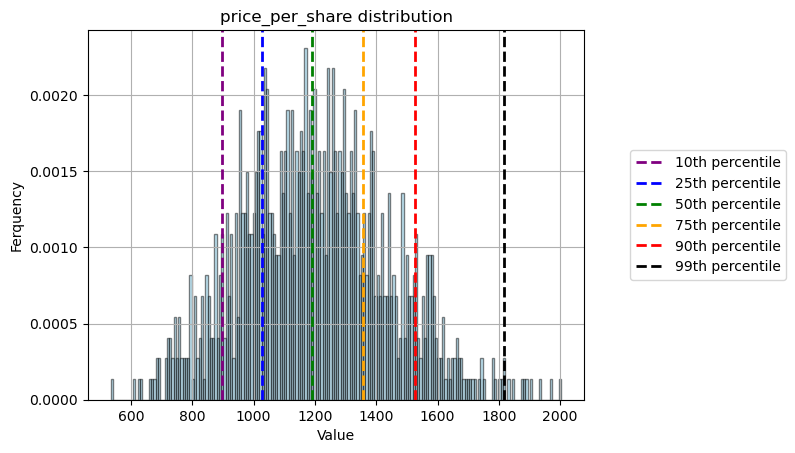

In [273]:


for col in DCF_df.columns:
    hist_plot(DCF_df[col],col)
    